In [34]:
import pandas as pd
from pathlib import Path
# counterfactual_results/nf=30_l=32_nt=10_nt=30_ne=5_kt=0.5_re=False_gemma-2-9b
path_format = "counterfactual_results/nf={n_feats}_l={layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_kt={kl_threshold}_re={random_explanations}_{model_last}"

base_cfg = {
    "layer": 32,
    "n_feats": 30,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 3.0,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
}

# load all results
def load_result(cfg):
    path = path_format.format(**cfg)
    
    # path = Path(path) / "generations.json"
    path = Path(path) / "generations_scores.json"
    df = pd.read_json(path)
    df = df.sort_values(by="max_delta_conditional_entropy", ascending=False)
    return df
base_df = load_result(base_cfg)
base_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explanations,explainer_prompts,explainer_examples,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
0,734.889122,2.817446,0,[[� �I had to chuckle knowing you'd get screwe...,[{'text': '� �I had to chuckle knowing you'd g...,"[{'prompt': ' Artist Facing Blank Canvas, Norm...","[writing, lettering, and numbers, writing, let...","[ Artist Facing Blank Canvas, Norman Rockwell,...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'writing, lettering, and numbers': 1.55956751...","{'writing, lettering, and numbers': 0.34089235...",2.421153,"writing, lettering, inscription"
8,697.339948,3.050811,12,[[ grounds. I can't think that Boyd would make...,[{'text': ' grounds. I can't think that Boyd w...,[{'prompt': ' California still hoping to do a ...,"[near-death experiences, death, death, death, ...",[ California still hoping to do a couple of sh...,[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'near-death experiences': 2.0820170403, 'deat...","{'near-death experiences': 0.5413017693000001,...",2.082017,near-death experiences
19,505.952927,3.068280,26,[[71.Film”The House I Live In.” 6:15 p.m. Main...,[{'text': '71.Film”The House I Live In.” 6:15 ...,"[{'prompt': ' the word 'world' apply?""Insofar ...","[arrival, events, arrivals, coming, emergence,...","[ the word 'world' apply?""Insofar as it disint...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'arrival': 0.7199912707, 'events': 0.43190430...","{'arrival': 0.24459898330000002, 'events': 0.1...",1.900315,"arrivals, coming, emergence, arrival, advent"
6,768.463250,2.789447,10,[[<bos> provided for its use will have to be c...,[{'text': ' provided for its use will have to ...,"[{'prompt': ' her father was in', 'top_p_incre...","[business, business, business, business, busin...","[ her father was in, founder, Abe Zimmerman. ...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...",{'business': 1.7360705376},{'business': 0.3330853105},1.736071,business
11,746.345177,2.981781,16,"[[ amount of time to evaluate them. A, 9.64062...",[{'text': ' amount of time to evaluate them. A...,[{'prompt': ' reserved for emergency situation...,"[education, education, education, education, a...","[ reserved for emergency situations, when pare...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'education, education, education': 0.33156542...","{'education, education, education': 0.23453512...",1.587816,"assessment, formative, tests, assessments, test"
1,521.300895,3.134515,2,[[\nMany players:\nhttp://sports.yahoo.com/ten...,[{'text': ' Many players: http://sports.yahoo....,"[{'prompt': ' the', 'top_p_increases': [0.1837...","[ranking, numbers, rankings, ranking, ordinal ...","[ the, -6.\n, Nick Clegg, right, speaks to th...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'ranking': 1.0911340396, 'numbers': 0.3274106...","{'ranking': 0.26822727490000003, 'numbers': 0....",1.363888,rankings
10,596.322552,2.997834,15,[[ carrier sheet 16 often comprises:\na) casca...,[{'text': ' carrier sheet 16 often comprises: ...,[{'prompt': ' was also added. The spring rigid...,"[materials, material, plastic, materials, mate...",[ was also added. The spring rigidity was cut ...,[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'materials': 1.2019028505, 'material': 1.3068...","{'materials': 0.3360954894, 'material': 0.3264...",1.306832,material
5,828.493169,3.046568,9,[[ and he has made up his mind — then don’t an...,[{'text': ' and he has made up 

In [35]:
base_df.iloc[2].completions

[{'text': '71.Film”The House I Live In.” 6:15 p.m. Main Street Landing Film House, ',
  'max_act': 18.59375,
  'completions': {'zeroed': '60 Lake St., Burlington. Free',
   'intervened': ' coming into the theater in Burlington Thursday night'}},
 {'text': ' known for being a member of the famous University of Michigan Fab Five. As I look back at the',
  'max_act': 9.1875,
  'completions': {'zeroed': ' NBA Draft Prospect I have written about in',
   'intervened': ' election of 1992,'}},
 {'text': '. Most workers felt completely alienated by this process."\nDuring the Accord years, the absence of high levels of rank and file pressure meant that the union bureaucracy was shaped by other forces. Labor was shifting to the right under the impact of the demands of capital. The',
  'max_act': 13.78125,
  'completions': {'zeroed': ' unions did not even try to keep up',
   'intervened': ' death of Michael Foot led to a bitter'}},
 {'text': 'dioceses prior to',
  'max_act': 40.53125,
  'completio

In [36]:
def get_sem_normalized_scores(df):
    def get_z_score(row):
        scores_by_expls = row["delta_conditional_entropy_by_explanation"]
        sems_by_expl = row["delta_conditional_entropy_sems_by_explanation"]
        best_expl = max(scores_by_expls, key=lambda x: scores_by_expls[x])
        best_score = scores_by_expls[best_expl]
        best_sem = sems_by_expl[best_expl]
        z_score = best_score / best_sem
        return z_score
    df["sem_normalized_max_delta_conditional_entropy"] = df.apply(get_z_score, axis=1)
    return df

base_df = get_sem_normalized_scores(base_df)
base_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explanations,explainer_prompts,explainer_examples,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation,sem_normalized_max_delta_conditional_entropy
0,734.889122,2.817446,0,[[� �I had to chuckle knowing you'd get screwe...,[{'text': '� �I had to chuckle knowing you'd g...,"[{'prompt': ' Artist Facing Blank Canvas, Norm...","[writing, lettering, and numbers, writing, let...","[ Artist Facing Blank Canvas, Norman Rockwell,...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'writing, lettering, and numbers': 1.55956751...","{'writing, lettering, and numbers': 0.34089235...",2.421153,"writing, lettering, inscription",4.432351
8,697.339948,3.050811,12,[[ grounds. I can't think that Boyd would make...,[{'text': ' grounds. I can't think that Boyd w...,[{'prompt': ' California still hoping to do a ...,"[near-death experiences, death, death, death, ...",[ California still hoping to do a couple of sh...,[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'near-death experiences': 2.0820170403, 'deat...","{'near-death experiences': 0.5413017693000001,...",2.082017,near-death experiences,3.846315
19,505.952927,3.068280,26,[[71.Film”The House I Live In.” 6:15 p.m. Main...,[{'text': '71.Film”The House I Live In.” 6:15 ...,"[{'prompt': ' the word 'world' apply?""Insofar ...","[arrival, events, arrivals, coming, emergence,...","[ the word 'world' apply?""Insofar as it disint...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'arrival': 0.7199912707, 'events': 0.43190430...","{'arrival': 0.24459898330000002, 'events': 0.1...",1.900315,"arrivals, coming, emergence, arrival, advent",3.673153
6,768.463250,2.789447,10,[[<bos> provided for its use will have to be c...,[{'text': ' provided for its use will have to ...,"[{'prompt': ' her father was in', 'top_p_incre...","[business, business, business, business, busin...","[ her father was in, founder, Abe Zimmerman. ...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...",{'business': 1.7360705376},{'business': 0.3330853105},1.736071,business,5.212090
11,746.345177,2.981781,16,"[[ amount of time to evaluate them. A, 9.64062...",[{'text': ' amount of time to evaluate them. A...,[{'prompt': ' reserved for emergency situation...,"[education, education, education, education, a...","[ reserved for emergency situations, when pare...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'education, education, education': 0.33156542...","{'education, education, education': 0.23453512...",1.587816,"assessment, formative, tests, assessments, test",3.092887
1,521.300895,3.134515,2,[[\nMany players:\nhttp://sports.yahoo.com/ten...,[{'text': ' Many players: http://sports.yahoo....,"[{'prompt': ' the', 'top_p_increases': [0.1837...","[ranking, numbers, rankings, ranking, ordinal ...","[ the, -6.\n, Nick Clegg, right, speaks to th...",[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'ranking': 1.0911340396, 'numbers': 0.3274106...","{'ranking': 0.26822727490000003, 'numbers': 0....",1.363888,rankings,3.988494
10,596.322552,2.997834,15,[[ carrier sheet 16 often comprises:\na) casca...,[{'text': ' carrier sheet 16 often comprises: ...,[{'prompt': ' was also added. The spring rigid...,"[materials, material, plastic, materials, mate...",[ was also added. The spring rigidity was cut ...,[[<bos>. I wired it to a simple on-off switch ...,"{'explanation': None, 'intervention_examples':...","{'materials': 1.2019028505, 'material': 1.3068...","{'materials': 0.3360954894, 'material': 0.3264...",1.306832,material,4.0025

In [10]:
import matplotlib.pyplot as plt

cfg = base_cfg.copy()
case_cfg = base_cfg.copy()
case_cfg["random_explanations"] = True

case_df = get_sem_normalized_scores(load_result(case_cfg))
control_df = get_sem_normalized_scores(load_result(cfg))
case_df.set_index("feat_idx", inplace=True)
control_df.set_index("feat_idx", inplace=True)

# case_scores = case_df["max_delta_conditional_entropy"].values
# control_scores = control_df["max_delta_conditional_entropy"].values
case_scores = case_df["sem_normalized_max_delta_conditional_entropy"].values
control_scores = control_df["sem_normalized_max_delta_conditional_entropy"].values

diff_key = [k for k in case_cfg.keys() if case_cfg[k] != cfg[k]][0]
plt.title(f"{diff_key} = {case_cfg[diff_key]} (control: {cfg[diff_key]})")
plt.hist(case_scores, bins=20, alpha=0.5, label="case", density=True)
plt.hist(control_scores, bins=20, alpha=0.5, label="control", density=True)
plt.xlabel("Sem normalized max delta conditional entropy")
plt.ylabel("Density")
plt.legend()
plt.show()



FileNotFoundError: File counterfactual_results/nf=300_l=32_nt=5_nt=40_ne=10_ss=10_rrd=False_re=True_gemma-2-9b/generations_scores.json does not exist

In [7]:
# join on feat_idx

joined_df = control_df.join(case_df, rsuffix="_case", how="inner")
len(joined_df), len(control_df), len(case_df)

NameError: name 'control_df' is not defined

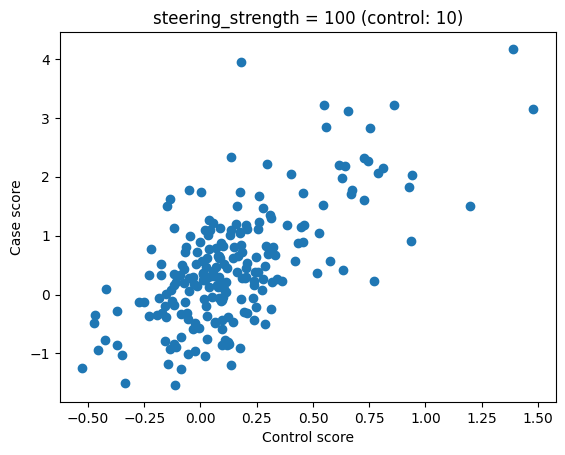

In [93]:
plt.scatter(joined_df["max_delta_conditional_entropy"], joined_df["max_delta_conditional_entropy_case"])
plt.xlabel("Control score")
plt.ylabel("Case score")
plt.title(f"{diff_key} = {case_cfg[diff_key]} (control: {cfg[diff_key]})")
plt.show()
